# Navigation Project

---

## Project Description

This document is the report of the first Udacity project for reinforcment learning. 

For this project, I have trained an agent to navigate and collect yellow bananas in a large, square world.

<img src="images/banana.gif">

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

* 0 - move forward.
* 1 - move backward.
* 2 - turn left.
* 3 - turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.

## Solution Approach

The solution follows the vanilla approach by [the original DQN paper](https://arxiv.org/abs/1312.5602).
But instead of having convolutional layers to derive the state from raw pixel data, we can directly access the crisp current state.
Therefore, the whole network architecture simplifies, such that I only need two deep layers with [ReLU activation](https://arxiv.org/pdf/1706.08098.pdf) for the Q-Network.
For further investigation, I evaluate the size of the hidden layers to find the best estimate following a fan-in approach for deeper layers.

The hyperparameter for training the Q-Network are as follows:

* DQN Learning Parameters
 * $n_{\text{episodes}}$ = 2000
 * $\epsilon_{\text{decay}}$ = 0.995
 * $\epsilon_{\text{start}}$ = 1.0
 * $\epsilon_{\text{end}}$ = 0.01
 * Replay buffer size = 10e5
 * Minibatch size = 64
 * $\Gamma$ (aka discount factor) = 0.99
 * $\tau$ (aka soft update of target parameters) = 1e-3
 * Learning rate = 5e-4
 * Update Interval between local and target network = 4
* DQN Network Architecture
 * Layer-Conections: Input -> ReLU Layer 1 -> RelU Layer 2 -> Output
 * Layer-Dimensionality [ReLU Layer 1, ReLU Layer 2]: [8,8], [16,8], [16,16], [32,8], [32,16], [32,32], [64,8], [64,16], [64,32], [64,64], [128,8], [128,16], [128,32], [128,64], [128,128]


## Evaluation

### 1. Preliminars for the Program Environment

In [1]:
!pip -q install ./python

from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import pickle
from pathlib import Path
from functions.dqn_agent import Agent
from functions.rl import DQN
from functions.helper import env_info, scores_stat, scores_plot

# Start the environment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

state_size, action_size = env_info(env, brain)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 2. Training the agent using a 2-Layer DQN with varying Layer-Sizes

In [2]:
n_episodes = 2000
eps_decay = 0.995
fc_units_power_min = 3
fc_units_power_max = 7
scores_fc_eval = []
for fc_1_units_power in np.arange(fc_units_power_min, fc_units_power_max+1):
    for fc_2_units_power in np.arange(fc_units_power_min, fc_1_units_power+1):
        # Allocate the agent
        agent = Agent(state_size=state_size,
                      action_size=action_size,
                      seed=0,
                      fc1_units=np.int(2**fc_1_units_power),
                      fc2_units=np.int(2**fc_2_units_power))
        # Define a config string
        filename =  str("_fc1-" + str(agent.fc1_units) +
                    "_fc2-" + str(agent.fc2_units) +
                    "_e-" + str(n_episodes) +
                    "_decay-" + str(eps_decay))
        print("Current config: " + filename)
        # Check if the scores are arcived, otherwise train it
        if not Path("eval/dict" + filename).is_file():
            # Train the agent
            dqn = DQN(agent = agent, env = env, brain = brain,
                      eps_decay = eps_decay,
                      verbose = True,
                      n_episodes = n_episodes,
                      max_t = 1000)
            # Archive the values
            scores = dqn.train(weights_location = "weights/network" + filename + ".pth")
            scores_fc_eval.append({"fc1_units": agent.fc1_units,
                                   "fc2_units": agent.fc2_units,
                                   "epsilodes": dqn.n_episodes,
                                   "decay": dqn.eps_decay,
                                   "scores": scores})
            with open("eval/dict" + filename, 'wb') as fp:
                pickle.dump(scores_fc_eval[-1], fp)
        else:
            scores_fc_eval.append(pickle.load( open( "eval/dict" + filename, "rb" ) ))
env.close()

Current config: _fc1-8_fc2-8_e-2000_decay-0.995
Current config: _fc1-16_fc2-8_e-2000_decay-0.995
Current config: _fc1-16_fc2-16_e-2000_decay-0.995
Current config: _fc1-32_fc2-8_e-2000_decay-0.995
Current config: _fc1-32_fc2-16_e-2000_decay-0.995
Current config: _fc1-32_fc2-32_e-2000_decay-0.995
Current config: _fc1-64_fc2-8_e-2000_decay-0.995
Current config: _fc1-64_fc2-16_e-2000_decay-0.995
Current config: _fc1-64_fc2-32_e-2000_decay-0.995
Current config: _fc1-64_fc2-64_e-2000_decay-0.995
Current config: _fc1-128_fc2-8_e-2000_decay-0.995
Current config: _fc1-128_fc2-16_e-2000_decay-0.995
Current config: _fc1-128_fc2-32_e-2000_decay-0.995
Current config: _fc1-128_fc2-64_e-2000_decay-0.995
Current config: _fc1-128_fc2-128_e-2000_decay-0.995


### 3. Evaluation

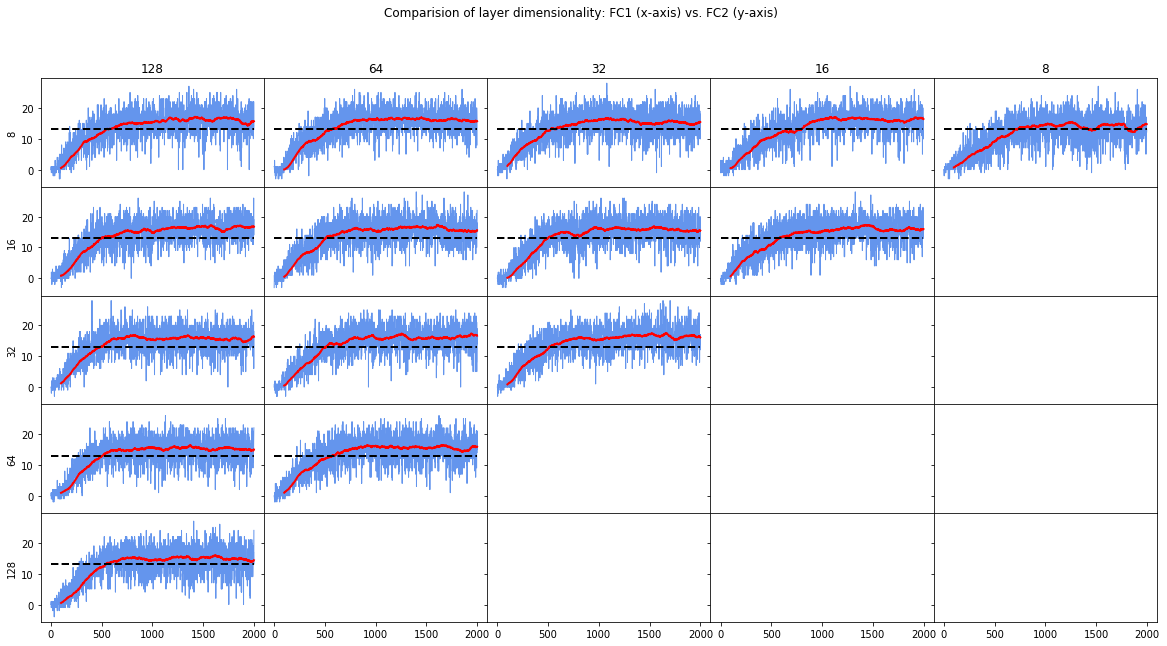

In [3]:
# Print the varios scores over different layer sizes
eval_threashold_idx, eval_max_score = scores_plot(scores = scores_fc_eval, threashold = 13, plot_num=fc_units_power_max - fc_units_power_min + 1, title="Comparision of layer dimensionality: FC1 (x-axis) vs. FC2 (y-axis)")

Corresponding index, where the average score exceeds 13 for the first time:

In [4]:
print(eval_threashold_idx)

[[ 543.  563.  525.  765.  698.]
 [ 489.  509.  497.  570.    0.]
 [ 488.  510.  514.    0.    0.]
 [ 510.  573.    0.    0.    0.]
 [ 541.    0.    0.    0.    0.]]


Corresponding maximum score achived

In [5]:
print(eval_max_score)

[[ 17.1   16.89  16.66  17.03  15.47]
 [ 17.14  17.34  16.85  17.3    0.  ]
 [ 16.84  17.32  17.47   0.     0.  ]
 [ 16.42  16.43   0.     0.     0.  ]
 [ 15.94   0.     0.     0.     0.  ]]


### 4. Conclusion

The evaluation shows some interesting insights into the layer dimensionalities, and how they affect the scores.
The former evaluations show to insights:
First, after which training epoch the score exceeds a score of +13 (c.f. the black dotted line in the figure).
Second, the average score after 2000 epochs (c.f. red line in the figure).
Both facts give us insights into the properties of *how much effort is necessary to beat the game* and *how good can the network adapt to the task, if we just let it train*.
One can see, that neither the smallest network size [8, 8], nor the biggest [128, 128] performes the best.
It might be quite obvious the the small network does not adapt to the state complexity.
On the other hand, one can assume that the bigger networks are more sensitive to find local optima.
Anyways, the tendecy is that networks with a classical fan-in structure perform better, since they are forced to extract more meaningful features along the bottleneck.
Further improvements can be done by implementing a double DQN, a dueling DQN, and/or prioritized experience replay.